## Human In The Loop

In [ ]:

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# command and interrupt are used for human-in-the-loop.
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]



In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b",temperature=0.5)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002206811A660>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002206811B230>, model_name='openai/gpt-oss-20b', temperature=0.5, model_kwargs={}, groq_api_key=SecretStr('**********'))

## graph with human assistance tool

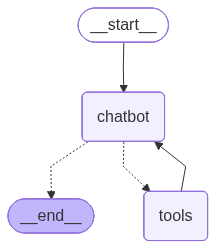

In [ ]:

graph_builder = StateGraph(State)

@tool
def human_assistance(query:str)->str:
    """Request assistance from a human."""
    human_response = interrupt({"query":query})
    return human_response["data"]

search_tool = TavilySearch(max_results=2)
tools=[search_tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


def chatbot(state:State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages":[message]}
graph_builder.add_node("chatbot", chatbot)

# add edges
graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)
# checkpointer to save the state after each node execution
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Visualize the graph
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
## testing human in the loop 
user_input = "I need some assistance and guidance with finding information about LangGraph.Could you request assistance for me?"
config = {"configurable" : {"thread_id":"1"}}

events = graph.stream({"messages": user_input},config=config,stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  

================================ Human Message =================================

I need some assistance and guidance with finding information about LangGraph.Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (fc_8fbeb27d-68e0-4a27-9c3e-e33d7c8b9781)
 Call ID: fc_8fbeb27d-68e0-4a27-9c3e-e33d7c8b9781
  Args:
    query: I need some assistance and guidance with finding information about LangGraph. Could you request assistance for me?


In [6]:
## human in the loop works!. now we capture human response and pass it  back to the chatbot.

human_response = ("We, the experts are here to help! We'd recommend you check out LangGraph documentaton for detailed information about it."
    " It's much more detailed and reliable.")
human_command = Command(resume={"data": human_response})

events = graph.stream(human_command,config,stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (fc_8fbeb27d-68e0-4a27-9c3e-e33d7c8b9781)
 Call ID: fc_8fbeb27d-68e0-4a27-9c3e-e33d7c8b9781
  Args:
    query: I need some assistance and guidance with finding information about LangGraph. Could you request assistance for me?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph documentaton for detailed information about it. It's much more detailed and reliable.


================================== Ai Message ==================================

Sure thing! I’ve requested assistance on your behalf. The experts responded with this recommendation:

> “We, the experts, are here to help! We'd recommend you check out the LangGraph documentation for detailed information about it. It’s much more detailed and reliable.”

Feel free to let me know if you’d like a quick summary of that documentation or help navigating it!
